In [34]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, Softmax
from scipy import signal
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [35]:
VIDEO_EXT = ('.avi', '.mp4')
NUM_FRAMES = 30
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 2
data_dir = "/Users/elijahadedamola/Documents/project_dataset/hockey_fight1"

In [36]:
spectrograms_list = []
labels = []

for file_name in os.listdir(data_dir):
    if not file_name.endswith(VIDEO_EXT):
        continue

    file_path = os.path.join(data_dir, file_name)
    cap = cv2.VideoCapture(file_path)

    frames = []
    while cap.isOpened() and len(frames) < NUM_FRAMES:
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        else:
            break

    cap.release()

    if len(frames) < NUM_FRAMES:
        continue

    # compute spectrogram
    f, t, Zxx = signal.stft(np.array(frames).mean(axis=0), nperseg=64, noverlap=32)
    spectrogram = np.abs(Zxx)[::-1]
    spectrogram = np.log(spectrogram + 1e-10)
    spectrogram = cv2.resize(spectrogram, (IMG_HEIGHT, IMG_WIDTH))
    
    # append to list of spectrograms and labels
    label = 1 if file_name.startswith('fi') else 0
    spectrograms_list.append(spectrogram)
    labels.append(label)

# convert to numpy arrays
spectrograms = np.array(spectrograms_list)
labels = np.array(labels)


In [37]:
print(spectrograms.shape)
print(spectrograms.dtype)

(1000, 128, 128, 13)
float64


In [38]:
# Data Preparation
X_train1, X_test1, y_train1, y_test1 = train_test_split(spectrograms, labels, test_size=0.2, random_state=1234)


In [39]:
# resize first feature to (128, 128, 3)

X_train1_resized = np.array([resize(img, (IMG_HEIGHT, IMG_WIDTH, 3)) for img in X_train1])
X_test1_resized = np.array([resize(img, (IMG_HEIGHT, IMG_WIDTH, 3)) for img in X_test1])


In [40]:
print(X_train1_resized.shape)
print(y_train1.shape)
print(X_test1_resized.shape)
print(y_test1.shape)

(800, 128, 128, 3)
(800,)
(200, 128, 128, 3)
(200,)


In [41]:
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
#model1.add(Dense(units=512, activation='relu'))
#model1.add(Dense(units=256, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))

# Train the Model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [42]:
# Training the Model

spectrogram_history = model1.fit(X_train1_resized, y_train1, batch_size=32, epochs=10)


Epoch 1/10
25/25 [==============================] - 10s 338ms/step - loss: 0.6732 - accuracy: 0.7312
Epoch 2/10
25/25 [==============================] - 9s 363ms/step - loss: 0.3185 - accuracy: 0.8675
Epoch 3/10
25/25 [==============================] - 10s 385ms/step - loss: 0.2361 - accuracy: 0.8950
Epoch 4/10
25/25 [==============================] - 10s 396ms/step - loss: 0.1632 - accuracy: 0.9500
Epoch 5/10
25/25 [==============================] - 10s 395ms/step - loss: 0.1856 - accuracy: 0.9250
Epoch 6/10
25/25 [==============================] - 10s 397ms/step - loss: 0.1223 - accuracy: 0.9538
Epoch 7/10
25/25 [==============================] - 10s 394ms/step - loss: 0.1011 - accuracy: 0.9625
Epoch 8/10
25/25 [==============================] - 10s 395ms/step - loss: 0.1090 - accuracy: 0.9575
Epoch 9/10
25/25 [==============================] - 10s 391ms/step - loss: 0.0898 - accuracy: 0.9650
Epoch 10/10
25/25 [==============================] - 10s 391ms/step - loss: 0.0770 - accurac

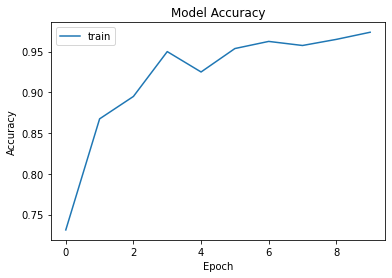

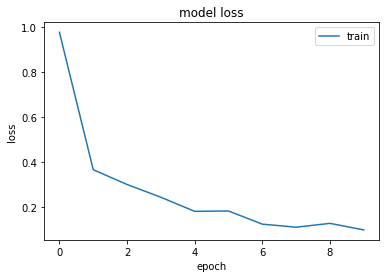

In [45]:
# Plot training history
plt.plot(spectrogram_history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='validation')
#plt.legend()
#plt.show()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [46]:
# Define a function to extract frames from a video file
def extract_frames(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH))
        frames.append(frame)
        frame_count += 1
        if frame_count == NUM_FRAMES:
            break
    cap.release()
    if len(frames) < NUM_FRAMES:
        padding = [np.zeros((IMG_HEIGHT, IMG_WIDTH, 3))] * (NUM_FRAMES - len(frames))
        frames.extend(padding)
    return frames

In [47]:
def prepare_dataset(data_dir):
    fight_frames = []
    non_fight_frames = []
    for file in os.listdir(data_dir):
        if file.startswith("fi"):
            file_path = os.path.join(data_dir, file)
            frames = extract_frames(file_path)
            fight_frames.extend(frames)
        elif file.startswith("no"):
            file_path = os.path.join(data_dir, file)
            frames = extract_frames(file_path)
            non_fight_frames.extend(frames)
    X = np.array(fight_frames + non_fight_frames)
    y = np.concatenate([np.ones(len(fight_frames)), np.zeros(len(non_fight_frames))])
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2)
    X_train2 = X_train2.reshape(X_train2.shape[0], IMG_HEIGHT, IMG_WIDTH, 3)
    X_test2 = X_test2.reshape(X_test2.shape[0], IMG_HEIGHT, IMG_WIDTH, 3)
    X_train2 = X_train2.astype('float32') / 255
    X_test2 = X_test2.astype('float32') / 255
    return X_train2, X_test2, y_train2, y_test2


In [48]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
#model2.add(Dense(128, activation='relu'))
#model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
X_train2, X_test2, y_train2, y_test2 = prepare_dataset(data_dir)

In [50]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(24000, 128, 128, 3)
(24000,)
(6000, 128, 128, 3)
(6000,)


In [51]:
X_train_2_resized = X_train2[:800]
y_train_2_resized = y_train2[:800]
X_test_2_resized = X_test2[:200]
y_test_2_resized = y_test2[:200]

In [52]:
frame_history = model2.fit(X_train_2_resized,y_train_2_resized,epochs=10, batch_size=32)

Epoch 1/10
25/25 [==============================] - 8s 290ms/step - loss: 0.5623 - accuracy: 0.6900
Epoch 2/10
25/25 [==============================] - 9s 362ms/step - loss: 0.2895 - accuracy: 0.8800
Epoch 3/10
25/25 [==============================] - 9s 354ms/step - loss: 0.2084 - accuracy: 0.9325
Epoch 4/10
25/25 [==============================] - 9s 347ms/step - loss: 0.1495 - accuracy: 0.9475
Epoch 5/10
25/25 [==============================] - 9s 349ms/step - loss: 0.1166 - accuracy: 0.9538
Epoch 6/10
25/25 [==============================] - 9s 357ms/step - loss: 0.0882 - accuracy: 0.9775
Epoch 7/10
25/25 [==============================] - 9s 366ms/step - loss: 0.0729 - accuracy: 0.9737
Epoch 8/10
25/25 [==============================] - 10s 383ms/step - loss: 0.0664 - accuracy: 0.9837
Epoch 9/10
25/25 [==============================] - 10s 403ms/step - loss: 0.0588 - accuracy: 0.9825
Epoch 10/10
25/25 [==============================] - 10s 397ms/step - loss: 0.0801 - accuracy: 0.9

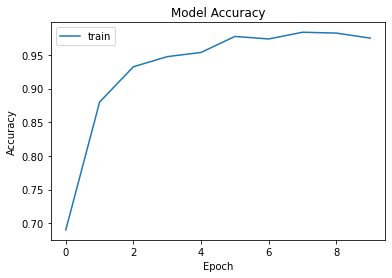

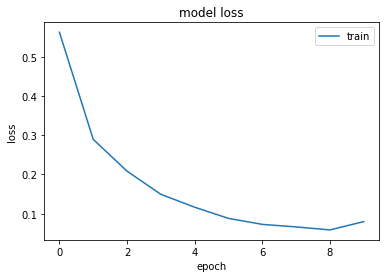

In [54]:
# Plot training history
plt.plot(frame_history.history['accuracy'], label='train')
#plt.plot(frame_history.history['val_accuracy'], label='validation')
#plt.legend()
#plt.show()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# summarize history for loss
plt.plot(frame_history.history['loss'])
#plt.plot(frame_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [55]:
#Remove the classifiers from the models
feature1 = Sequential(model1.layers[:-1])
feature2 = Sequential(model2.layers[:-1])


In [56]:
#Extract the features for training
feature_model_1_scores = feature1.predict(X_train1_resized)
feature_model_2_scores = feature2.predict(X_train_2_resized)

25/25 [==============================] - 2s 86ms/step


In [57]:
# Concatenate the extracted training features
concatenated_features = np.concatenate((feature_model_1_scores, feature_model_2_scores), axis=1)


In [58]:
# Define a new model for binary classification using sigmoid activation
combined_model = Sequential()
combined_model.add(Dense(64, activation='relu', input_shape=(concatenated_features.shape[1],)))
combined_model.add(Dense(32, activation='relu'))
combined_model.add(Dense(1, activation='sigmoid'))

# Compile the new model
combined_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [59]:
# Train the new model
history_training = combined_model.fit(concatenated_features, y_train1, epochs=10, validation_split=0.2)

Epoch 1/10
20/20 [==============================] - 1s 21ms/step - loss: 0.4614 - accuracy: 0.8109 - val_loss: 0.1105 - val_accuracy: 0.9500
Epoch 2/10
20/20 [==============================] - 1s 31ms/step - loss: 0.2390 - accuracy: 0.9281 - val_loss: 0.2133 - val_accuracy: 0.9187
Epoch 3/10
20/20 [==============================] - 1s 26ms/step - loss: 0.1221 - accuracy: 0.9547 - val_loss: 0.0542 - val_accuracy: 0.9937
Epoch 4/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0913 - accuracy: 0.9672 - val_loss: 0.0434 - val_accuracy: 0.9875
Epoch 5/10
20/20 [==============================] - 0s 20ms/step - loss: 0.0507 - accuracy: 0.9797 - val_loss: 0.0497 - val_accuracy: 0.9937
Epoch 6/10
20/20 [==============================] - 0s 18ms/step - loss: 0.0373 - accuracy: 0.9828 - val_loss: 0.0699 - val_accuracy: 0.9688
Epoch 7/10
20/20 [==============================] - 0s 17ms/step - loss: 0.0308 - accuracy: 0.9875 - val_loss: 0.0463 - val_accuracy: 0.9937
Epoch 8/10
20

In [70]:
#Evaluate the accuracy on the training set
training_loss, training_accuracy = combined_model.evaluate(concatenated_features, y_train1)


25/25 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9987


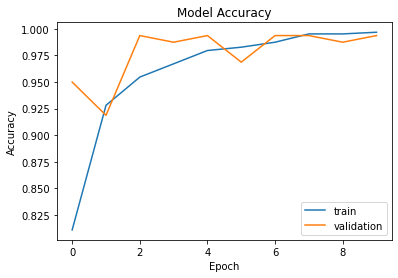

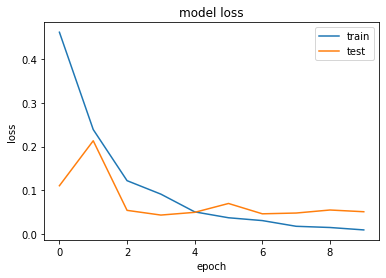

In [71]:
# Plot training history
plt.plot(history_training.history['accuracy'], label='train')
plt.plot(history_training.history['val_accuracy'], label='validation')
#plt.legend()
#plt.show()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# summarize history for loss
plt.plot(history_training.history['loss'])
plt.plot(history_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

25/25 [==============================] - 0s 4ms/step
[[395   0]
 [  1 404]]


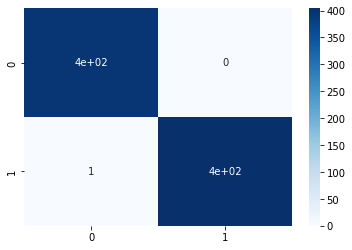

In [100]:
# Make predictions on the validation set
y_prob = combined_model.predict(concatenated_features)
y_pred = (y_prob > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_train1, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
print(cm)
plt.show()

In [60]:
#Generate model_1_scores and model_2_scores for testing
feature_modeltest1_scores = feature1.predict(X_test1_resized)
feature_modeltest2_scores = feature2.predict(X_test_2_resized)

7/7 [==============================] - 1s 95ms/step


In [62]:
# Concatenate the extracted testing features
concatenated_features_test = np.concatenate((feature_modeltest1_scores, feature_modeltest2_scores), axis=1)


In [63]:
# Define a new model for binary classification using sigmoid activation
combined_model_test = Sequential()
combined_model_test.add(Dense(64, activation='relu', input_shape=(concatenated_features_test.shape[1],)))
combined_model_test.add(Dense(32, activation='relu'))
combined_model_test.add(Dense(1, activation='sigmoid'))

# Compile the new model
combined_model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [64]:
# Train the new model
history_testing = combined_model_test.fit(concatenated_features_test, y_test1, epochs=10, validation_split=0.2)

Epoch 1/10
5/5 [==============================] - 1s 46ms/step - loss: 0.4470 - accuracy: 0.8250 - val_loss: 0.8198 - val_accuracy: 0.7500
Epoch 2/10
5/5 [==============================] - 0s 25ms/step - loss: 0.3104 - accuracy: 0.8625 - val_loss: 0.7593 - val_accuracy: 0.8250
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 0.1467 - accuracy: 0.9563 - val_loss: 0.8052 - val_accuracy: 0.8000
Epoch 4/10
5/5 [==============================] - 0s 41ms/step - loss: 0.2348 - accuracy: 0.9312 - val_loss: 0.4452 - val_accuracy: 0.8750
Epoch 5/10
5/5 [==============================] - 0s 46ms/step - loss: 0.2212 - accuracy: 0.9187 - val_loss: 0.3851 - val_accuracy: 0.9000
Epoch 6/10
5/5 [==============================] - 0s 35ms/step - loss: 0.1684 - accuracy: 0.9438 - val_loss: 0.4426 - val_accuracy: 0.9250
Epoch 7/10
5/5 [==============================] - 0s 38ms/step - loss: 0.0320 - accuracy: 0.9812 - val_loss: 0.4858 - val_accuracy: 0.9000
Epoch 8/10
5/5 [===========

In [69]:
# Evaluate the accuracy on the test set
test_loss, test_accuracy = combined_model_test.evaluate(concatenated_features_test, y_test1)


7/7 [==============================] - 0s 4ms/step - loss: 0.0892 - accuracy: 0.9750


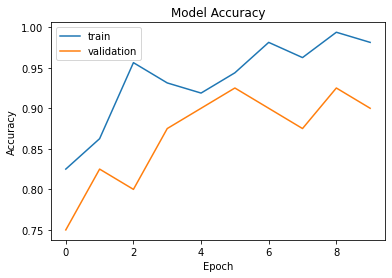

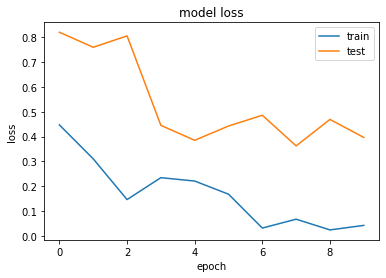

In [72]:
# Plot testing history
plt.plot(history_testing.history['accuracy'], label='train')
plt.plot(history_testing.history['val_accuracy'], label='validation')
#plt.legend()
#plt.show()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# summarize history for loss
plt.plot(history_testing.history['loss'])
plt.plot(history_testing.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

7/7 [==============================] - 0s 5ms/step
[[104   1]
 [  4  91]]


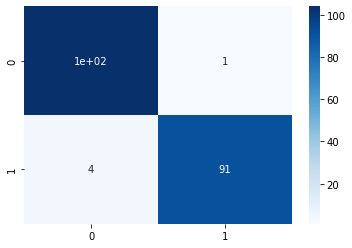

In [101]:
# Make predictions on the validation set
y_prob2 = combined_model_test.predict(concatenated_features_test)
y_pred2 = (y_prob2 > 0.5).astype(int)

# Generate the confusion matrix
cm2 = confusion_matrix(y_test1, y_pred2)
sns.heatmap(cm2, annot=True, cmap='Blues')
print(cm2)
plt.show()